# **Applying DRL for FIR Filter Implementation - Stage 1 - Section 3** 

## Scope - *MDP Modeling of the Adaptive FIR Filters*
References:- the book, *Deep Reinforcement Learning for Wireless Communications and Networking*

In [3]:
import os, sys, time, copy
import wave
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
from scipy.fft import fft, rfft, fftshift, fftfreq
from scipy.signal import convolve, freqz

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DDPG
from stable_baselines3.common.base_class import BaseAlgorithm, VecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

sys.path.insert(1, '../')
from helper import to_min_size_int_array, Spectrum, LPF, apply_filter, mean_L1_dist, SNR

2023-10-25 06:33:07.644906: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 06:33:07.960316: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 06:33:07.960360: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 06:33:07.961972: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 06:33:08.110479: I tensorflow/core/platform/cpu_feature_g

In [4]:
# Let's first load the audio files
log_path = "audio_files/"
src_audio_name = 'vignesh'
target_audio_file = src_audio_name + '-target-MONO.wav'
jammed_audio_file = src_audio_name + '-jammed-MONO.wav'

if not os.path.exists(log_path+target_audio_file):
    raise Exception(f"the target audio signal, {log_path+target_audio_file}, doesn't exist.")
sampling_rate, target_signal = wavfile.read(log_path+target_audio_file)

if not os.path.exists(log_path+jammed_audio_file):
    raise Exception(f"the jammed audio signal, {log_path+jammed_audio_file}, doesn't exist.")
sampling_rate_, jammed_signal = wavfile.read(log_path+jammed_audio_file)

if sampling_rate != sampling_rate_:
    Exception(f"the two sampling rates are not equal, {sampling_rate} and {sampling_rate_}")
print(f"audio files have been successfully loaded: target - {log_path+target_audio_file}, jammed - {log_path+jammed_audio_file}")

# basic information 
print(f"sampling rate    : {sampling_rate} Hz")
print(f"number of samples: {len(target_signal)}")

audio files have been successfully loaded: target - audio_files/vignesh-target-MONO.wav, jammed - audio_files/vignesh-jammed-MONO.wav
sampling rate    : 44100 Hz
number of samples: 136476


- A **Markov Decision Process** (MDP), a discrete-time stochastic control process, which is heavily used to model Reinforcement Learning (RL) problems, has 5 key components: **state/observation** ($S$), **action** ($A$), **transition dynamics** ($P$), **reward** ($r$), and **discounting factor** ($\gamma$). 

### **Action**
- In the MDP model of the proposed adaptive FIR filter, the **action** would represent the change applied to the filter coefficients in a given timestep. 
- <Mention that we would initialize the filter coefficients to a near optimal solution and would constraint the maximum change that can be added to a filter coefficinet in a time step, which allow the agent to explore near the provided optimal solution. It can put the exploration in the right place or it can also unnecessarily constraint the exploration.>
- <Mention that choosing the filter coefficients directly is not a good choice of action because it make it harder to explore>
- Since FIR filter coefficients can be given by an 1 dimensional array of real numbers (numpy array object with shape (N, ) where N is the filter length). 
- To achieve the preferred property of constant phase and group delays (linear phase response), we can restrict the FIR filter impulse response $h[n]$ to be symmetrical about its midpoint. And for the simplicity, we will further constraint the filter length to be odd; therefore, the impulse response of the filter must be symmetric over the sample $(N-1)/2$. 
- Therefore, to specify a particular instance of the FIR filter, we just want to provide $(N-1)/2$ elements, and hence, the action space is given by the shape `((N-1)/2, )`. 

### **State** 
- My first suggestion for the **states** of the MDP model of the specified Adaptive FIR Filter is to use **fixed length sections/sub-sequences of the receiving jammed signal**. 
- Remember, in a MDP modeling of an RL problem, a state (observation) must satisfy the *Markov Property*, which states that "once the current state is known, the information gathered from old experiences may not be necessary, and it is a sufficient statistic to predict the next action to take". 
- So, we have to first verify that a sub-sequence of the received signal of length N has sufficient information about the overall spectrum of the received signal. (If you don't get the point here, think about taking individual time samples of the recevied jammed signal ($N=1$) as the state; it has no information about the overall frequency distribution of the received signal, so a learning agent cannot take meaningful actions to remove the interference lurking behind the sample sequence.)
- Let's consider a sequence length, $N$, of $100$. 

seperation between two sub-sequences: 13647 (<class 'numpy.uint32'>)


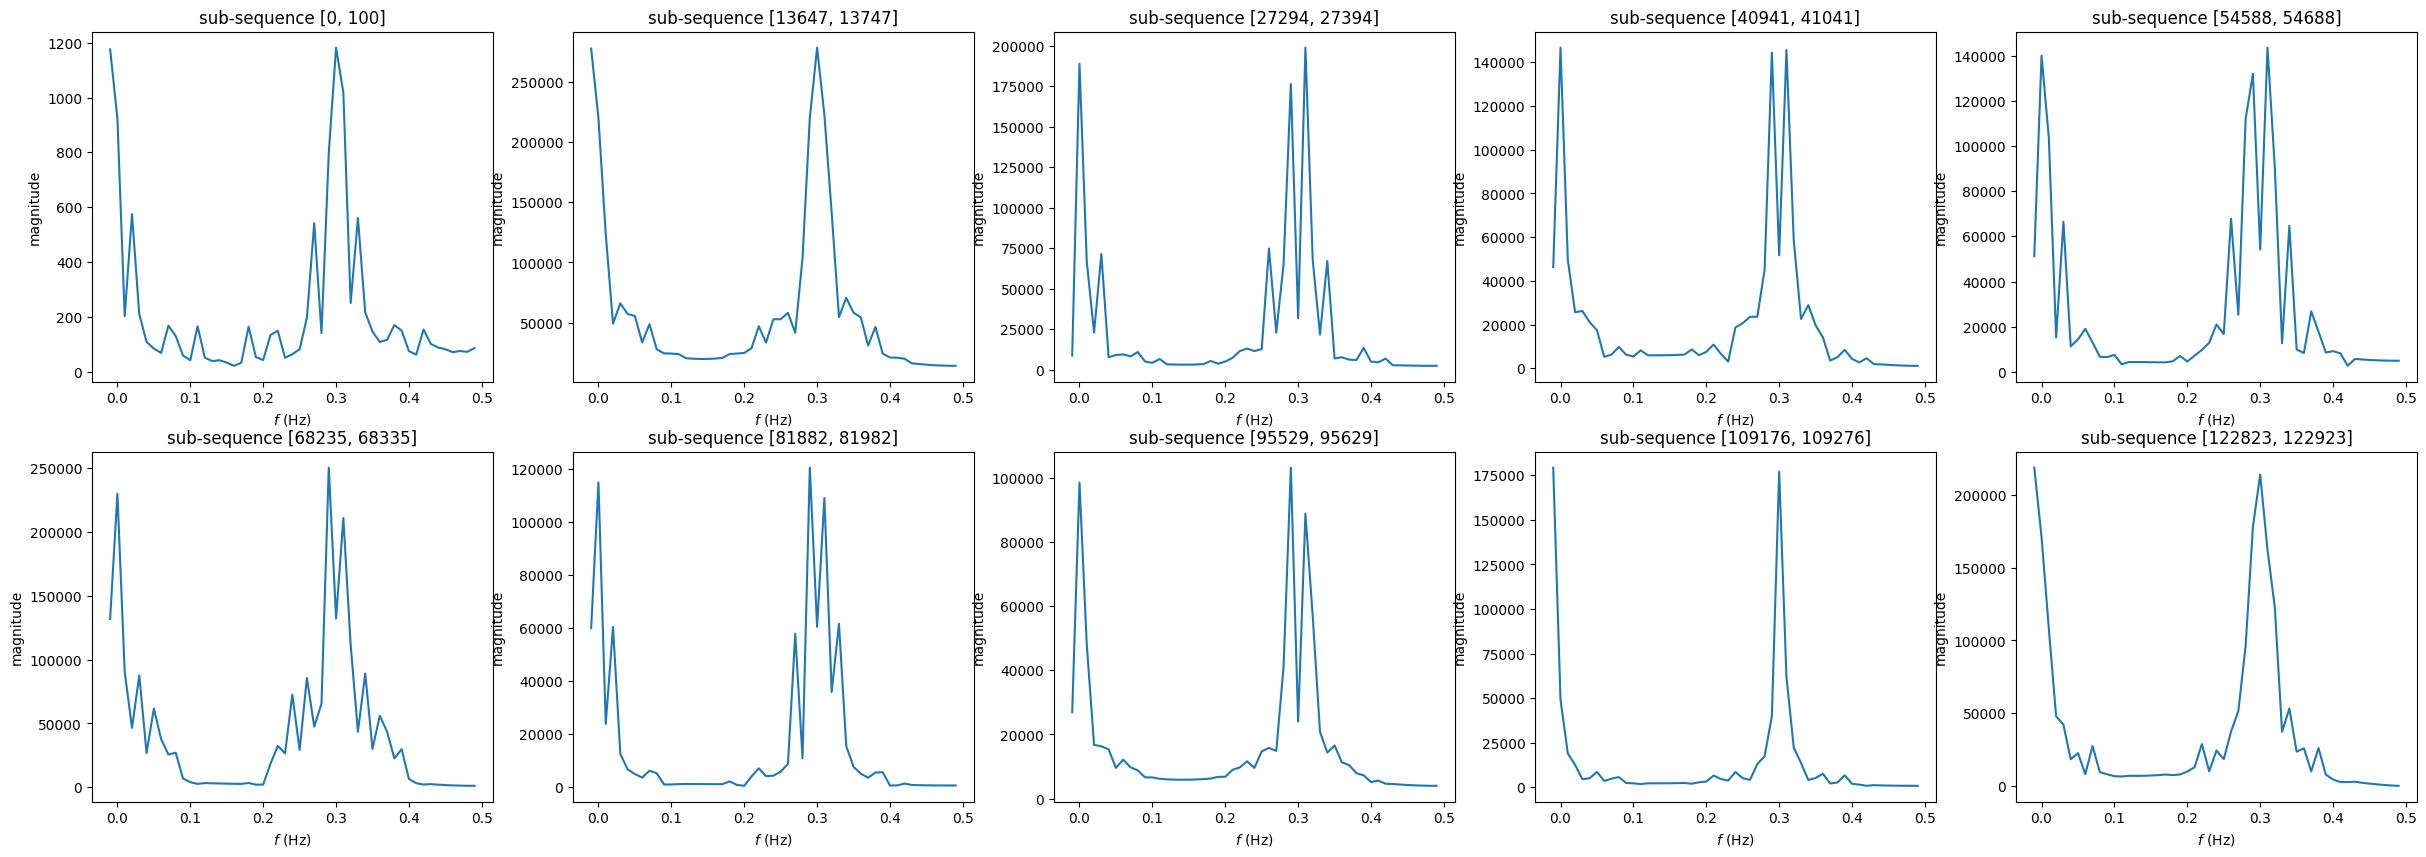

In [6]:
# finding the spectrum information stored in a sub-sequence of length N in the received signal

# jammed_signal = np.concatenate((np.zeros(1000), jammed_signal))
fig, axs = plt.subplots(2, 5, figsize=(30,10))

N = 100 # the size/length of a sub-sequence
S = np.floor(len(jammed_signal)/10).astype(np.uint32) # seperation size between sub-sequences
print(f"seperation between two sub-sequences: {S} ({type(S)})")
if S < 100:
    raise Exception(f"the provided signal is not long enough for the following code")
for i in range(10):
    sub_sequence = jammed_signal[S*i : S*i + N]
    axs[i//5, i%5].plot(*Spectrum(sub_sequence))
    axs[i//5, i%5].set_title(f"sub-sequence [{S*i}, {S*i + N}]")
    axs[i//5, i%5].set_xlabel("$f$ (Hz)")
    axs[i//5, i%5].set_ylabel("magnitude")

### Building the RL Environment
- Following code is based on the Google Colab tutorial docuement, *Creating a custom gym environment*, given in Stable Baselines3 Examples/Full Tutorial, https://github.com/araffin/rl-tutorial-jnrr19/tree/sb3. 
- Note that DDPG is designed for episodic tasks; therefore, training a DDPG agent/model over a single long episode may not learn anything at all. 
- So, we have to incorporate short episodes into our environment, while controlling the behavior of the resest operation between episode switches, thus a series of episodes correspond to a continuous learning process. 

In [11]:
# creating the RL environment for the adaptive FIR filter

class ReceiverEnv(gym.Env):
    """
    Custom environment representing the receiver of the adaptive FIR filter.

    :param S: the length of the signal partition considered as the state;
              the action, which is the change applied to the filter coefficients, would be determined based on the frequency spectrum of this partition. 
    :param N: the filter length; note that only odd filter lengths are accepted. 
    """

    MIN_SIG_PARTITION_SIZE = 20
    MAX_COEFFICIENT_CHANGE = 1
    MAX_STEP_COUNT = 10

    def __init__(self, S: int, N: int, cut_off_freq: float, src_audio: str, src_dir: str, render_mode: str):
        super(ReceiverEnv, self).__init__()

        # ------------------- setting the input parameters -------------------
        if S < self.MIN_SIG_PARTITION_SIZE: 
            raise Exception(f"the signal partition size (S) must be greater than {self.MIN_SIG_PARTITION_SIZE}.")
        if N%2 == 0: # if N is even
            raise Exception("filter length (N) must be odd.")
        
        self.S = S
        self.N = N
        self.cut_off_freq = cut_off_freq
        
        target_audio_file = src_dir + src_audio + '-target-MONO.wav'
        jammed_audio_file = src_dir + src_audio + '-jammed-MONO.wav'
        if not os.path.exists(target_audio_file):
            raise Exception(f"the specified source target audio file path {target_audio_file} does not exist.")
        R, target_signal = wavfile.read(target_audio_file)

        if not os.path.exists(jammed_audio_file):
            raise Exception(f"the specified source jammed audio file path {jammed_audio_file} does not exist.")
        _, jammed_signal = wavfile.read(jammed_audio_file)

        self.target_signal = target_signal
        self.jammed_signal = jammed_signal
        self.sampling_rate = R

        self.render_mode = render_mode # we do not implement here rendering though

        # defining the Action space
        action_shape = (int((N+1)/2), )
        self.action_space = spaces.Box(low=-self.MAX_COEFFICIENT_CHANGE, high=self.MAX_COEFFICIENT_CHANGE, shape=action_shape, dtype=np.float32)

        # defining the State space 
        state_shape = (S+N-1, )
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=state_shape, dtype=np.int32)

        # ------------------- initalizing env variables -------------------
        # initial filter - a near optimal solution 
        self.filter = LPF(self.N, self.cut_off_freq, self.sampling_rate)[1]

        self.offset = int((N-1)/2) # initial offset to place the filter 
        self.partition_start = self.offset
        
        partition = self.jammed_signal[self.partition_start - self.offset : self.partition_start + self.S + self.offset]
        self.state = partition

        # for debugging 
        self.step_count = 0
        self.filter_buffer = np.zeros((10, *self.filter.shape))
        self.filter_buffer[0] = self.filter

    def reset(self, seed=None, options=None):
        """
        Resets the environment at the start of the learning/training process. 
        Returns the initial state and an information dict.
        """
        super().reset(seed=seed, options=options)

        # resets the step counter
        # self.step_count = 0

        # reset the filter 
        # self.filter = LPF(self.N, self.cut_off_freq, self.sampling_rate)[1]

        # resets the partition_start
        # self.partition_start = self.offset

        # configuring the initial state 
        # partition = self.jammed_signal[self.partition_start - self.offset : self.partition_start + self.S + self.offset]
        # self.state = partition

        return self.state, {}
    
    def step(self, action):
        """
        Takes a step within the environment by taking the action. 
        Returns a 5-element tuple: (next_state, reward, terminated, truncated, info).
        """
        
        self.step_count += 1
        # print(f"step no: {self.step_count}")

        if self.N == 5 and np.all(action == np.array([1, -1, 1])):
            action = self.action_space.sample()

        # load the previous state, the partition of the signal
        # note that the action, tuning of the filter coefficients, is based on this signal partition
        partition = self.state 
        
        # update the filter 
        self.filter = np.concatenate((action[-1:0:-1], action))
        if self.step_count < 10: 
            self.filter_buffer[self.step_count] = self.filter
        if self.step_count == 10:
            np.save('logs/filter_arrays.npy', arr=self.filter_buffer)

        filtered_partition = apply_filter(self.filter, partition)[self.offset : -self.offset]
        target_partition   = self.target_signal[self.partition_start : self.partition_start + self.S]
        
        # reward = -mean_L1_dist(filtered_partition, target_partition)
        reward = SNR(target_partition, filtered_partition)
        if np.isnan(reward):
            print(f"state:  {partition}\nfilter: {self.filter}\nreward: {reward}") 
            raise Exception("SNR becomes infinite")

        # take a partition to be the next state
        self.partition_start += self.S
        if self.partition_start + self.S + self.offset > len(self.jammed_signal):
            # the partition has reached the end of the signal
            # reset the partition_start to the start of the signal
            self.partition_start = self.offset
            print(f"step {self.step_count} - resetting back to the start of the signal")
        partition = self.jammed_signal[self.partition_start - self.offset : self.partition_start + self.S + self.offset]

        # update the variables
        self.state = partition 

        # for debugging 
        # if self.step_count % 100 == 0: print(f"step: {self.step_count}")

        truncated  = False # not relevant here
        if self.step_count % self.MAX_STEP_COUNT == 0:
            truncated = True
        
        terminated = False
        info = {}
        return self.state, reward, terminated, truncated, info
    
    def render(self):
        """
        Visualaize the steps
        """
        # print(f"step no: {self.step_count}")
        pass

    def close(self):
        pass


In [12]:
# verify the operation of the custom environment 
env_ = ReceiverEnv(S=100, N=11, cut_off_freq=5_400, src_audio="vignesh", src_dir="../stage_1/audio_files/", render_mode=None)

# If the environment don't follow the interface, an error will be thrown
check_env(env_, warn=True)

step: 1,action: [-0.34601167  0.9004543   0.35356608], reward: [-7.533148]
step: 2,action: [ 0.6261968   0.06000674 -0.28359398], reward: [-3.9202895]
step: 3,action: [0.3132927  0.5563916  0.04605503], reward: [5.166236]
step: 4,action: [-0.5197631 -0.2265774  0.2898622], reward: [-4.795064]
step: 5,action: [-0.8080411 -0.387838  -0.8692855], reward: [-12.789974]
step: 6,action: [-0.6087796   0.877068    0.67019117], reward: [-10.479506]
step: 7,action: [ 0.63492566 -0.1227999  -0.11075708], reward: [-3.417164]
step: 8,action: [0.6685941  0.7060051  0.42266223], reward: [-5.097123]
step: 9,action: [-0.44393146  0.4148245   0.5464275 ], reward: [-6.5333962]
step: 10,action: [-0.85375565  0.886878   -0.03114067], reward: [-6.3231816]


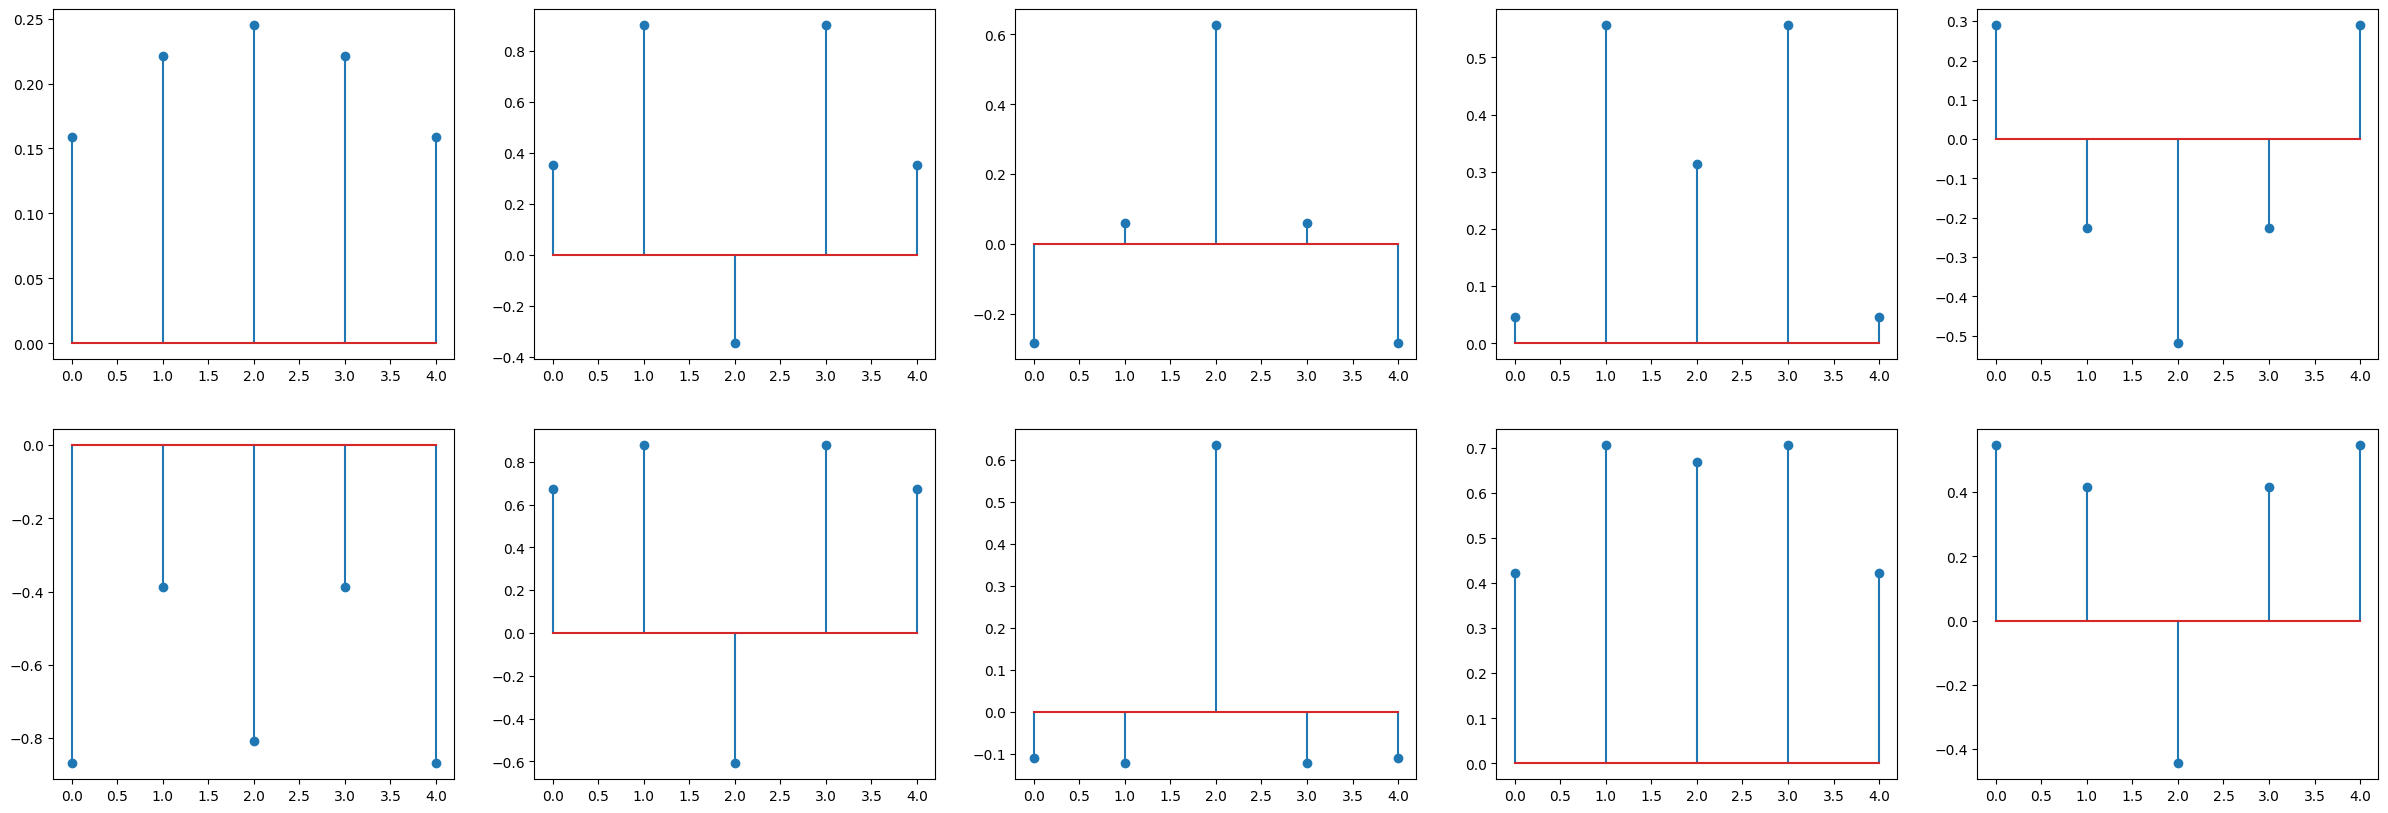

In [6]:
# instantiate the env
vec_env = make_vec_env(ReceiverEnv, n_envs=1, env_kwargs=dict(S=100, N=5, cut_off_freq=5_400, src_audio="vignesh", src_dir="../stage_1/audio_files/", render_mode=None))

state = vec_env.reset()
# print(filter_array)

done = False
step = 0
while not done:
    step += 1
    action = vec_env.action_space.sample()
    next_state, reward, done, _ = vec_env.step([action])
    if step <= 10: print(f"step: {step},action: {action}, reward: {reward}")

filter_array = np.load('logs/filter_arrays.npy')
# print(filter_array)

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))
for i in range(10):
    ax[i//5, i%5].stem(filter_array[i])

In [13]:
# generate a DDPG learning agent/model
vec_env = make_vec_env(ReceiverEnv, n_envs=1, env_kwargs=dict(S=100, N=5, cut_off_freq=5_400, src_audio="vignesh", src_dir="../stage_1/audio_files/", render_mode=None))
model = DDPG("MlpPolicy", vec_env, verbose=0)

# evaulate the agent before training
mean_rwd, std_rwd = evaluate_policy(model, vec_env, n_eval_episodes=1000, deterministic=True)
print(f"from SB3 evaulate_policy -> before training: mean reward = {mean_rwd}, std deviation of reward = {std_rwd}")

step 1364 - resetting back to the start of the signal
step 2728 - resetting back to the start of the signal
step 4092 - resetting back to the start of the signal
step 5456 - resetting back to the start of the signal
step 6820 - resetting back to the start of the signal
step 8184 - resetting back to the start of the signal
step 9548 - resetting back to the start of the signal
from SB3 evaulate_policy -> before training: mean reward = -99.788026492, std deviation of reward = 14.803690556021554


- We may have to develop our own policy evaluation function because the in-built SB3 `evaluate_policy` function accumulates the rewards over the entire length of the episode and returns an *episodic mean*. This measurement is not an accurate performance metric for our case. 
- What we want is the total reward averaged over all the timesteps of training, so it indicated how good the filtering is at a particular timestep in average.  

In [14]:
def Evaluate(model: BaseAlgorithm, env: VecEnv, n_eval_episodes: int):
    """
    A custom policy/agent evaluation function
    """
    
    # This function will only work for a single environment

    # initially, reset the environment 
    state = env.reset()
    rewards = []
    
    for _ in range(n_eval_episodes):
        done = False
        while not done:
            action, _ = model.predict(state, deterministic=True)
            temp = state
            state, reward, done, _ = env.step(action)
            rewards.append(reward)

    mean_reward = np.mean(rewards)
    std_reward  = np.std(rewards)

    return mean_reward, std_reward, rewards

In [16]:
# evaulate the agent before training using our own custom evaluate function
vec_env = make_vec_env(ReceiverEnv, n_envs=1, env_kwargs=dict(S=100, N=5, cut_off_freq=5_400, src_audio="vignesh", src_dir="../stage_1/audio_files/", render_mode=None))
mean_rwd, std_rwd, rewards = Evaluate(model, env=vec_env, n_eval_episodes=1000)
print(f"from custom Evaluate -> before training: mean reward = {mean_rwd}, std deviation of reward = {std_rwd}")

step 1364 - resetting back to the start of the signal
step 2728 - resetting back to the start of the signal
step 4092 - resetting back to the start of the signal
step 5456 - resetting back to the start of the signal
step 6820 - resetting back to the start of the signal
step 8184 - resetting back to the start of the signal
step 9548 - resetting back to the start of the signal
from custom Evaluate -> before training: mean reward = -9.976839065551758, std deviation of reward = 3.310868263244629


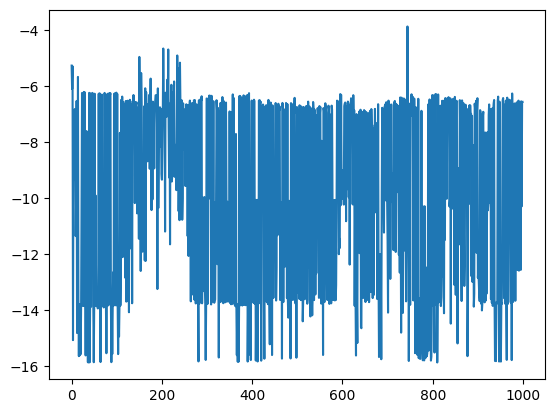

In [17]:
plt.plot(rewards[:1000])

In [22]:
# train the agent 
vec_env = make_vec_env(ReceiverEnv, n_envs=1, env_kwargs=dict(S=100, N=5, cut_off_freq=5_400, src_audio="vignesh", src_dir="../stage_1/audio_files/", render_mode=None))
model = DDPG("MlpPolicy", vec_env, gamma=0.5, verbose=0)
model.learn(total_timesteps=10_000)

step 1364 - resetting back to the start of the signal
step 2728 - resetting back to the start of the signal
step 4092 - resetting back to the start of the signal
step 5456 - resetting back to the start of the signal
step 6820 - resetting back to the start of the signal
step 8184 - resetting back to the start of the signal
step 9548 - resetting back to the start of the signal


step 10912 - resetting back to the start of the signal
step 12276 - resetting back to the start of the signal
step 13640 - resetting back to the start of the signal
step 15004 - resetting back to the start of the signal
step 16368 - resetting back to the start of the signal
step 17732 - resetting back to the start of the signal
step 19096 - resetting back to the start of the signal
from custom Evaluate -> before training: mean reward = -12.415862083435059, std deviation of reward = 1.8542168140411377


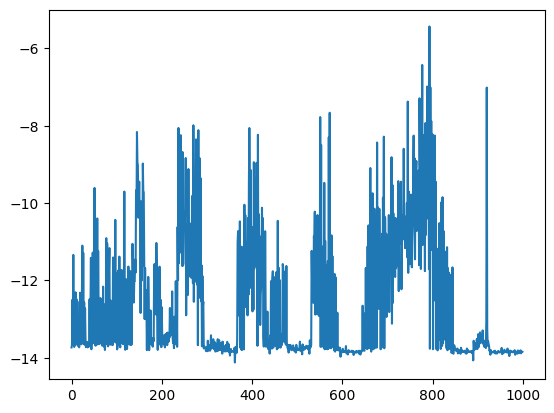

In [23]:
# evaluate the model after training 
mean_rwd, std_rwd, rewards = Evaluate(model, env=vec_env, n_eval_episodes=1000)
print(f"from custom Evaluate -> before training: mean reward = {mean_rwd}, std deviation of reward = {std_rwd}")
plt.plot(rewards[:1000])